https://arxiv.org/abs/1512.03385  
这篇论文首次提出了残差网络（ResNet）的概念，解决了深层网络训练中梯度消失和退化问题。核心思想是通过“恒等映射”短路（skip connection）来学习残差函数，让网络更容易优化。  

1. ResNet‑18 网络结构  
ResNet‑18 是 ResNet 系列中较浅的一种，包含 18 层可学习层（不计入 ReLU、池化等层）。其大致结构如下：  

Input (224×224×3)  
↓  
7×7 conv, stride=2, 64 filters  
3×3 max pool, stride=2  
↓  
[ 2 × (3×3 conv, 64 filters) ]   ← Residual Block ×2  
[ 2 × (3×3 conv, 128 filters) ]  ← Residual Block ×2 (first block stride=2)  
[ 2 × (3×3 conv, 256 filters) ]  ← Residual Block ×2 (first block stride=2)  
[ 2 × (3×3 conv, 512 filters) ]  ← Residual Block ×2 (first block stride=2)  
↓  
Global Average Pooling  
Fully Connected (512 → 1000 for ImageNet)  
Softmax  
每个 Residual Block 都包含两层 3×3 卷积和一次跳跃连接（identity shortcut）。  
在通道数扩张的那一层（如 64→128），使用 1×1 卷积在 shortcut 分支上做下采样和升维。  

2. 关键设计理念  
残差学习（Residual Learning）  
原始网络学习目标映射 H(x)，而 ResNet 学习残差 F(x) = H(x) − x，最后输出 F(x) + x。  
这样做能让深层网络更容易优化，减少梯度消失。  
短路连接（Skip Connection）  
恒等映射直接将输入 x 加到后面层的输出上。  
保证信息和梯度可以跨层直接传递。  
批量归一化（Batch Normalization）  
在每次卷积后都加 BN，加速收敛并稳定训练。  

3. 资源与教程  
官方 PyTorch 文档  
ResNet 源码和使用示例：https://pytorch.org/vision/stable/models.html#id14  
博客与解读  
“A Guide to ResNet” by Lilian Weng：https://lilianweng.github.io/lil-log/2017/12/31/residual-networks.html  
“Deep Residual Networks Explained” by Brandon Amos：https://amitness.com/2019/05/resnets-explained/  
视频课程  
Stanford CS231n Lecture on ResNet：https://www.youtube.com/watch?v=Z2tP6B_3b2o  

In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# —— 一、超参数和路径设置 —— #
DATA_DIR     = r"D:\UNSW\2025T1\COMP9517\proj\ResNet\Aerial_Landscapes"
BATCH_SIZE   = 32
NUM_EPOCHS   = 20
LEARNING_RATE= 1e-4
WEIGHT_DECAY = 1e-5
PATIENCE_LR  = 3       # ReduceLROnPlateau patience
PATIENCE_ES  = 5       # Early stopping patience
VAL_SPLIT    = 0.1     # 验证集比例
TEST_SPLIT   = 0.2     # 测试集比例
NUM_CLASSES  = 15      # 类别数

In [3]:
# —— 二、数据增强与加载 —— #
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [4]:
def get_dataloaders():
    # 加载全量数据集
    full_ds = datasets.ImageFolder(DATA_DIR, transform=train_transform)
    total_size = len(full_ds)
    val_size   = int(total_size * VAL_SPLIT)
    test_size  = int(total_size * TEST_SPLIT)
    train_size = total_size - val_size - test_size

    train_ds, val_ds, test_ds = random_split(full_ds, [train_size, val_size, test_size])
    # 验证/测试集使用不同的 transform
    val_ds.dataset.transform  = val_test_transform
    test_ds.dataset.transform = val_test_transform

    # DataLoader（Windows 上可将 num_workers 设为 0）
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"数据集划分 -> 训练: {train_size}, 验证: {val_size}, 测试: {test_size}")
    return train_loader, val_loader, test_loader, full_ds.classes

# —— 三、模型、损失、优化器、调度器 —— #
def build_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    return model

# —— 四、训练与验证函数 —— #
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc  = running_corrects / total_samples
    return epoch_loss, epoch_acc

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc  = running_corrects / total_samples
    return epoch_loss, epoch_acc

In [5]:
# —— 五、主训练循环（含早停） —— #
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, val_loader, test_loader, classes = get_dataloaders()
    model     = build_model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=0.5, patience=PATIENCE_LR,
                                                     verbose=True)

    best_val_loss = float('inf')
    es_counter    = 0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc     = eval_one_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
              f"Time: {time.time()-start_time:.1f}s")

        # 早停与保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_resnet18.pth')
            es_counter = 0
        else:
            es_counter += 1
            if es_counter >= PATIENCE_ES:
                print("Early stopping triggered. Training finished.")
                break

    # —— 六、测试评估 —— #
    model.load_state_dict(torch.load('best_resnet18.pth'))
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    test_acc = accuracy_score(y_true, y_pred)
    print(f"\nTest Accuracy: {test_acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("resnet18_confusion_matrix.png")
    # plt.show()

    # —— 七、训练曲线可视化 —— #
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'],   label='Val Loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Loss Curve"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'],   label='Val Acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Accuracy Curve"); plt.legend()

    plt.tight_layout()
    plt.savefig("resnet18_training_curves.png")
    # plt.show()


数据集划分 -> 训练: 8400, 验证: 1200, 测试: 2400


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 0.4320, Acc: 0.8814 | Val   Loss: 0.1617, Acc: 0.9533 | Time: 33.6s
Epoch 2/20 | Train Loss: 0.1041, Acc: 0.9700 | Val   Loss: 0.1298, Acc: 0.9650 | Time: 32.2s
Epoch 3/20 | Train Loss: 0.0513, Acc: 0.9867 | Val   Loss: 0.1103, Acc: 0.9692 | Time: 31.9s
Epoch 4/20 | Train Loss: 0.0367, Acc: 0.9917 | Val   Loss: 0.1181, Acc: 0.9625 | Time: 31.7s
Epoch 5/20 | Train Loss: 0.0312, Acc: 0.9915 | Val   Loss: 0.1175, Acc: 0.9667 | Time: 34.3s
Epoch 6/20 | Train Loss: 0.0324, Acc: 0.9902 | Val   Loss: 0.1787, Acc: 0.9558 | Time: 35.2s
Epoch 7/20 | Train Loss: 0.0293, Acc: 0.9920 | Val   Loss: 0.1466, Acc: 0.9617 | Time: 30.7s
Epoch 8/20 | Train Loss: 0.0107, Acc: 0.9976 | Val   Loss: 0.0936, Acc: 0.9750 | Time: 30.5s
Epoch 9/20 | Train Loss: 0.0055, Acc: 0.9990 | Val   Loss: 0.0980, Acc: 0.9733 | Time: 29.8s
Epoch 10/20 | Train Loss: 0.0041, Acc: 0.9994 | Val   Loss: 0.0962, Acc: 0.9775 | Time: 29.5s
Epoch 11/20 | Train Loss: 0.0060, Acc: 0.9988 | Val   Loss: 0.1021, A

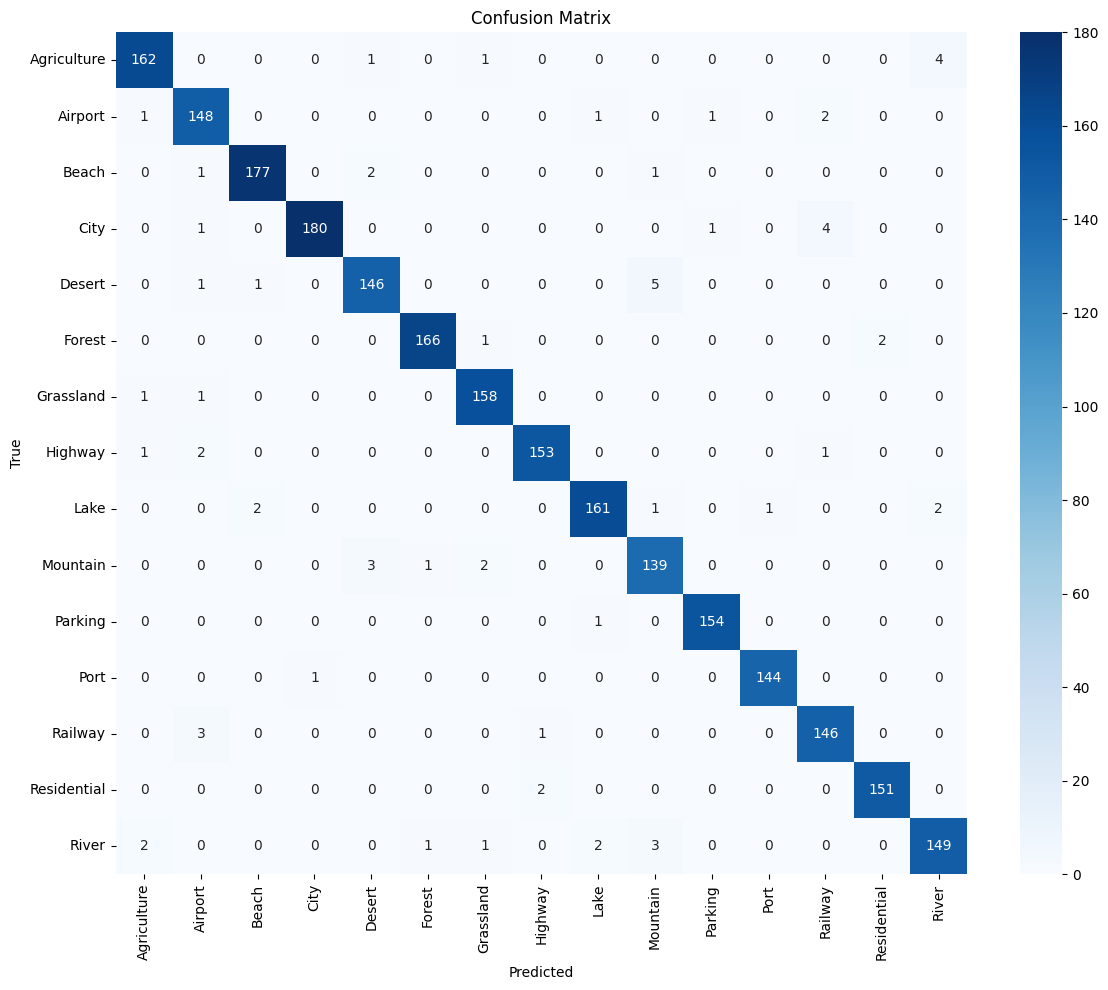

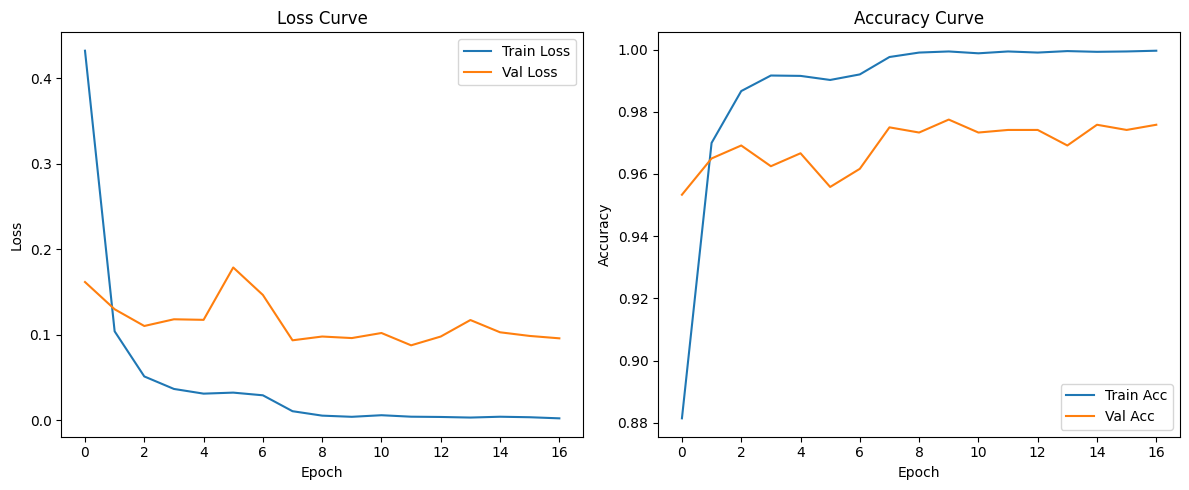

In [6]:
if __name__ == '__main__':
    main()